In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Change working directory to be current folder
import os
os.chdir('/content/drive/MyDrive/MyColab/ISSMPM')
!ls

Mounted at /content/drive
 dataset
 DelawarePainDatabase_StimulusCharacterization_forOSF.xlsx
 FaceDetection_CNN_classification.ipynb
 FaceDetection_CNN_Regression_2022_04_01_06_24_08.ipynb
 FaceDetection_CNN_Regression_2022_04_01_16_23_41.ipynb
 FaceDetection_CNN_Regression_2022_04_04_16_23_41.ipynb
 FaceDetection_CNN_Regression_2022_04_09.ipynb
 FaceDetection_CNN_Regression_TransferLearning_2022_04_09.ipynb
 FaceDetection_CNN_Regression_TransferLearning_2022_05_12.ipynb
 FaceDetection_CNN_Regression_TransferLearning.ipynb
 FaceDetection_CNN_Regression_TransferLearning_withVideoDataframe.ipynb
 FaceDetection_haar.ipynb
 FaceDetection.ipynb
 faceexp-comparison-data-test-public.csv
 PainRecognition_CNN_Regression.ipynb
 PainRecognition_TransferLearning.ipynb
 training
'Video Processing2.ipynb'
'Video Processing.ipynb'


In [ ]:
#installation of mediapipe library
!pip install mediapipe

     |████████████████████████████████| 32.8 MB 228 kB/s 


In [ ]:
#import library required
import cv2
import os
import numpy as np
import random
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.callbacks import ModelCheckpoint,CSVLogger
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Input,Dropout,Conv2D,MaxPooling2D,BatchNormalization,Activation
from tensorflow.keras.utils import to_categorical,plot_model
from tensorflow.keras import optimizers,regularizers
import sklearn
from sklearn.model_selection import train_test_split
import datetime as dt

import tensorflow as tf
from google.colab.patches import cv2_imshow
import mediapipe as mp
import imutils
import pickle

print("Versions of key libraries")
print("---")
print("tensorflow: ", tf.__version__)
print("numpy:      ", np.__version__)
print("matplotlib: ", matplotlib.__version__)
print("sklearn:    ", sklearn.__version__)

Versions of key libraries
---
tensorflow:  2.8.0
numpy:       1.21.6
matplotlib:  3.2.2
sklearn:     1.0.2


In [ ]:
#Load the predicted pain expression of the video withSpec_nopain_incorrectpose provided by the CNN Regression model
with open('/content/drive/MyDrive/MyColab/ISSMPM/training/withSpec_nopain_incorrectpose_CNNRegression.pkl', "rb") as f:
  withSpec_nopain_incorrectpose_predicts = pickle.load(f)
#Load the predicted pain expression of the video withSpec_pain_correctpose provided by the CNN Regression model
with open('/content/drive/MyDrive/MyColab/ISSMPM/training/withSpec_pain_correctpose_CNNRegression.pkl', "rb") as f:
  withSpec_pain_correctpose_predicts = pickle.load(f)
#Check the mean square error predicted on the CNN Regression model on the testing dataset
print(f"The mean square error is {withSpec_pain_correctpose_predicts.get('mean')}") if withSpec_pain_correctpose_predicts.get('mean')==withSpec_nopain_incorrectpose_predicts.get('mean') else print()

The mean square error is 0.38631193620628423


Text(0.5, 1.0, 'Pain Expression with no pain face')

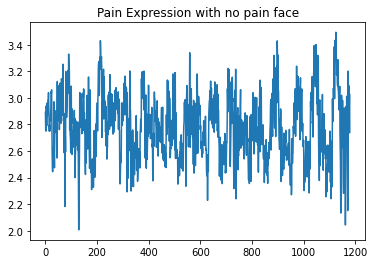

In [ ]:
#deduct the root mean square error on all the predicted pain expression of the no pain face on the video frames(withSpec_nopain_incorrectpose), they are considered as the expected pain expression
import math
expected_withSpec_nopain_incorrectpose_predicts = [(face,predicts[0]-math.sqrt(withSpec_nopain_incorrectpose_predicts.get('mean'))) for face,predicts in withSpec_nopain_incorrectpose_predicts.get('data')] 
plt.figure()
plt.plot([ value[1] for value in expected_withSpec_nopain_incorrectpose_predicts], label="reg_nopain")
plt.title('Pain Expression with no pain face',fontsize=12)



Text(0.5, 1.0, 'Pain Expression with pain face')

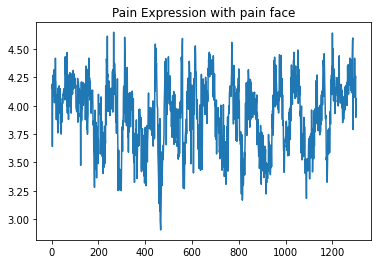

In [ ]:
#add the root mean square error on all the predicted pain expression of the pain face on the video frames(withSpec_pain_correctpose), they are considered as the expected pain expression
expected_withSpec_pain_correctpose_predicts = [(face,predicts[0]+math.sqrt(withSpec_pain_correctpose_predicts.get('mean'))) for face,predicts in withSpec_pain_correctpose_predicts.get('data')] 
plt.figure()
plt.plot([ value[1] for value in expected_withSpec_pain_correctpose_predicts], label="reg_pain")
plt.title('Pain Expression with pain face',fontsize=12)

In [ ]:
#We use randomSample to pick 90 sample from the lists.
randomSample = 90

# from the plot of the graph, we observe that the pain intensity lower than 2.8 will be considered as no pain face
NoPainFaceFromSelfVideo = random.sample([(f'SelfNoPainFace{index}',value[0],value[1]) for index, value in enumerate(expected_withSpec_nopain_incorrectpose_predicts) if value[1]<2.8],randomSample)

# from the plot of the graph, we observe that the pain intensity greater than 3.8 will be considered as pain face
PainFaceFromSelfVideo = random.sample([(f'SelfPainFace{index}',value[0],value[1]) for index, value in enumerate(expected_withSpec_pain_correctpose_predicts) if value[1]>3.8],randomSample)
del withSpec_pain_correctpose_predicts,withSpec_nopain_incorrectpose_predicts,expected_withSpec_nopain_incorrectpose_predicts,expected_withSpec_pain_correctpose_predicts

In [ ]:
"""
import Delaware pain database which provided a set of painful expressions and corresponding norming data

Refer to the link: https://psyarxiv.com/kjez5/
Target: naming convention described in read-me file.

Expression_Highest: Categorical variable representing the highest average emotion rating (e.g., from "Fear_Expression" to "Pain_Expression"); for example, if a given expression had an average "Anger_Expression" rating of 4.00, and all other ratings from "Fear_Expression" to "Pain_Expression" were 2.00, that stimulis would have a value of "anger" for "Expression_Highest"

Pain_Expression: Average rating of pain for a given expression made by a particular target; 1 ("not at all") to 7 ("extremely") scale, in response to "How much does this face look like it's in pain?"

The CNN model will be trained to predict the pain expression of the face in the self-recorded video.
"""

usecols=['Target','Expession_Highest','Pain_Expression']
colType=['string','string','string']
dtypeDF = dict(zip(usecols,colType))
normingData = pd.read_excel('DelawarePainDatabase_StimulusCharacterization_forOSF.xlsx','DPD_NormingData',dtype=dtypeDF,usecols=usecols)
normingData.head()

/usr/local/lib/python3.7/dist-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,Target,Pain_Expression,Expession_Highest
0,DPD_1_WM34_p5c,5.9555556,pain
1,DPD_1_WM39_p5c,5.82,pain
2,DPD_1_OF8_p4c,2.0487805,sad
3,DPD_1_AF12_p4c,2.2857143,surprised
4,DPD_1_AF12_p6c,2.6428571,sad


In [ ]:
#filter out no facial expression
painNormingData = normingData[normingData['Expession_Highest']=='pain']
nonePainNormingData = normingData[(normingData['Expession_Highest']!='.') & (normingData['Expession_Highest']!='pain')][:272]
normingData = pd.concat([painNormingData,nonePainNormingData]).sort_index()

In [ ]:
#Convert pain expression to float
def is_number_tryexcept(s):
    """ Returns True is string is a number. """
    try:
        float(s)
        return True
    except ValueError:
        return False
filterNormingData = normingData[normingData['Pain_Expression'].apply(is_number_tryexcept)].astype({'Pain_Expression':'float'})
filterNormingData['Pain_Expression'].describe()

count    544.000000
mean       3.350831
std        1.094587
min        1.150000
25%        2.424689
50%        3.339394
75%        4.195255
max        5.955556
Name: Pain_Expression, dtype: float64

In [ ]:
#Define variable to store image list
image_file_list = sorted(os.listdir('dataset'))
dfImageList = filterNormingData[(filterNormingData['Target']+'.JPG').isin(image_file_list)]
Pain_Class = dfImageList['Expession_Highest']
Pain_Expression = dfImageList['Pain_Expression']
expression_image_list = list(dfImageList['Target']+'.JPG')
neutral_image_list = [imagedir for imagedir in  image_file_list if imagedir not in list(filterNormingData['Target']+'.JPG')]
del normingData,filterNormingData, dfImageList,painNormingData,nonePainNormingData

In [ ]:
#Use Medipipe Face Detection Pretained Model to execute Face Detection and crop out the face from the image list
mp_face_detection = mp.solutions.face_detection
image_Morethan1Detection = []
no_face_image = []
preproc_img = []

#Loop all the file defined in the image list
for imageName in expression_image_list:
  img = cv2.imread(f'dataset/{imageName}')

  with mp_face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5) as face_detection:

    # Convert the BGR image to RGB and process it with MediaPipe Face Detection.
    results = face_detection.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

    #Skip if there is no face detected.
    if not results.detections:
      no_face_image.append(imageName)
      continue

    #Skip if there are multiple faces detected.
    if len(results.detections)>1:
      image_Morethan1Detection.append(imageName)
      continue

    #Retrieve the coordination of the face from the result of detection
    row, column,channel = img.shape
    y = int(results.detections[0].location_data.relative_bounding_box.ymin*row)
    h = int(results.detections[0].location_data.relative_bounding_box.height*row)
    x = int(results.detections[0].location_data.relative_bounding_box.xmin*column)
    w = int(results.detections[0].location_data.relative_bounding_box.width*column)
    face = img[y:y + h, x:x + w]

    #Resize all the images to 100x100 first amd expand to 224x224. This is because the face detected on the self recorded video has an average size of 100x100 but the input size of the transfer learning model is 224x224
    resized = cv2.resize(face, (100, 100))
    resized = cv2.resize(resized, (224, 224))

    #All te image are converted into grayscale as the pain expression should be color invariant. Stack as three channel to fit the transfer learning model
    resized = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
    resized = np.dstack((resized,resized,resized))

    #Image data is required to be normalized to fit the transfer learning model
    preprocessed = preprocess_input(resized)
    preproc_img.append((imageName,preprocessed))
    if len(preproc_img)%10==0:
      print(f'{len(preproc_img)} images are processed!')


10 images are processed!
20 images are processed!
30 images are processed!
40 images are processed!
50 images are processed!
60 images are processed!
70 images are processed!
80 images are processed!
90 images are processed!
100 images are processed!
110 images are processed!
120 images are processed!
130 images are processed!
140 images are processed!
150 images are processed!
160 images are processed!
170 images are processed!
180 images are processed!
190 images are processed!
200 images are processed!
210 images are processed!
220 images are processed!
230 images are processed!
240 images are processed!
250 images are processed!
260 images are processed!
270 images are processed!
280 images are processed!
290 images are processed!
300 images are processed!
310 images are processed!
320 images are processed!
330 images are processed!
340 images are processed!
350 images are processed!
360 images are processed!
370 images are processed!
380 images are processed!
390 images are proces

In [ ]:
#Merge the face collected from the video frames with the Delaware pain face images.
#All the frames from PainFaceFromSelfVideo are classified as pain while the frames from NoPainFaceFromSelfVideo are classified as no pain

mergedPainClass = list(Pain_Class)
mergedPainExpression = list(Pain_Expression)
for imageName, face, intensity in NoPainFaceFromSelfVideo:
  resized = cv2.resize(face, (100, 100))
  resized = cv2.resize(resized, (224, 224))
  resized = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
  resized = np.dstack((resized,resized,resized))
  preprocessed = preprocess_input(resized)
  preproc_img.append((imageName,preprocessed))
  mergedPainClass.append('normal')
  mergedPainExpression.append(intensity)
for imagename, face, intensity in PainFaceFromSelfVideo:
  resized = cv2.resize(face, (100, 100))
  resized = cv2.resize(resized, (224, 224))
  resized = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
  resized = np.dstack((resized,resized,resized))
  preprocessed = preprocess_input(resized)
  preproc_img.append((imageName,preprocessed))
  mergedPainClass.append('pain')
  mergedPainExpression.append(intensity)

In [ ]:
#Perform image preprocessing to flip the image horizontally and expand the training data
flip_preproc_img = [(f'flip_{imageName}',cv2.flip(data,1)) for imageName, data in preproc_img]
main_image_list = preproc_img + flip_preproc_img
dat = np.array([data for imageName, data in main_image_list]).reshape(-1,224,224,3)

#extend the label of the classes as the data has been duplicated after the flip processing
class_lbl = mergedPainClass
class_lbl.extend(class_lbl)
class_lbl = np.array([([0,1] if expression=='pain' else [1,0] ) for expression in class_lbl]).reshape(-1,2)

#extend the label of the pain expression as the data has been duplicated after the flip processing
reg_lbl = mergedPainExpression
reg_lbl.extend(reg_lbl)
reg_lbl = np.array(reg_lbl).reshape(-1,1)

(X_train, X_test, y_class_train, y_class_test,y_reg_train, y_reg_test) = train_test_split(dat, class_lbl,reg_lbl, test_size=0.25, stratify=class_lbl, random_state=331)
del mergedPainClass, mergedPainExpression, Pain_Intensity, Pain_expression,dat, preproc_img,flip_preproc_img, NoPainFaceFromSelfVideo, PainFaceFromSelfVideo, main_image_list

In [ ]:
#Define the ResNet50 Transfer Learning model
optmz = SGD(lr=1e-4, momentum=0.9, decay=1e-4/20)
base = ResNet50(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
modelname   = 'PainRecognition'
epochs = 50
def createModel():
  h = base.output

  x1 = Flatten(name="flatten_class")(h)
  x1 = Dense(16, activation="relu",name='dense16_class')(x1)
  x1 = Dropout(0.25)(x1)
  output1 = Dense(2, activation="softmax",name='class')(x1)

  x2 = Conv2D(4096,(2,2),padding='same',name='reg1_conv2d')(h)
  x2 = Activation('relu')(x2)
  x2 = AveragePooling2D(pool_size=(3, 3))(x2)
  x2 = Dropout(0.25)(x2)

  x2 = Flatten(name="flatten_reg")(x2)
  x2 = Dense(128,activation='relu',name='dense128_reg')(x2)
  x2 = Dropout(0.5)(x2)
  x2 = Dense(16,activation='relu',name='dense16_reg')(x2)
  x2 = Dropout(0.25)(x2)
  output2 = Dense(1,activation='linear',name='reg')(x2)
 
  model = Model(inputs=base.input, outputs=[output1,output2])
  for layer in base.layers:
    if layer.name not in ['conv5_block3_3_conv','conv5_block3_3_bn']:
      layer.trainable = False
  model.compile(loss=['categorical_crossentropy', 'mse'], optimizer=optmz, metrics=['accuracy','MeanSquaredError'])
  return model

model       = createModel()
modelGo     = createModel()
model.summary()

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [ ]:
#Define the callback list and the csv file to store the training records
currenttime     = str(dt.datetime.now().strftime("%Y_%m_%d_%H_%M_%S"))
folderpath      = '/content/drive/MyDrive/MyColab/ISSMPM/training/'
filepath        = f'{folderpath}{modelname}_transferlearning_withVideoDataframe_Final.hdf5'
checkpoint      = ModelCheckpoint(filepath, 
                                  monitor='val_loss', 
                                  verbose=0, 
                                  save_best_only=True, 
                                  mode='min')
csvfilename     = f'{folderpath}{modelname}_transferlearningDataframe_Final.csv'
csv_logger      = CSVLogger(csvfilename)
callbacks_list  = [checkpoint,csv_logger]

print("Callbacks created:")
print(callbacks_list[0])
print(callbacks_list[1])
print('')
print("Path to model:", filepath)
print("Path to log:  ", folderpath+modelname+'.csv')

Callbacks created:

Path to model: /content/drive/MyDrive/MyColab/ISSMPM/training/PainRecognition_transferlearning_withVideoDataframe_Final.hdf5
Path to log:   /content/drive/MyDrive/MyColab/ISSMPM/training/PainRecognition.csv


In [ ]:
model.fit(X_train, 
          [y_class_train,y_reg_train],
          validation_data=(X_test, [y_class_test,y_reg_test]),
          epochs=epochs, 
          batch_size=24,
          shuffle=True,
          callbacks=callbacks_list)

Epoch 1/50
39/39 [==============================] - 26s 539ms/step - loss: 4.0326 - class_loss: 0.6767 - reg_loss: 3.3559 - class_accuracy: 0.6547 - class_mean_squared_error: 0.2277 - reg_accuracy: 0.0000e+00 - reg_mean_squared_error: 3.3559 - val_loss: 2.8944 - val_class_loss: 0.5444 - val_reg_loss: 2.3500 - val_class_accuracy: 0.7134 - val_class_mean_squared_error: 0.1866 - val_reg_accuracy: 0.0000e+00 - val_reg_mean_squared_error: 2.3500
Epoch 2/50
39/39 [==============================] - 21s 532ms/step - loss: 2.6704 - class_loss: 0.4865 - reg_loss: 2.1839 - class_accuracy: 0.7340 - class_mean_squared_error: 0.1652 - reg_accuracy: 0.0000e+00 - reg_mean_squared_error: 2.1839 - val_loss: 1.5462 - val_class_loss: 0.4589 - val_reg_loss: 1.0874 - val_class_accuracy: 0.7524 - val_class_mean_squared_error: 0.1570 - val_reg_accuracy: 0.0000e+00 - val_reg_mean_squared_error: 1.0874
Epoch 3/50
39/39 [==============================] - 17s 439ms/step - loss: 2.3201 - class_loss: 0.4030 - reg_l

In [ ]:
#Load the weights of the model
modelGo.load_weights(filepath)
print("Model weights loaded from:", filepath)

modelGo.compile(loss=['categorical_crossentropy', 'mse'],
                   optimizer=optmz,
                  metrics=['accuracy','MeanSquaredError'])

predicts_class,predicts_reg    = modelGo.predict(X_test)
print("Prediction completes.")

Model weights loaded from: /content/drive/MyDrive/MyColab/ISSMPM/training/PainRecognition_transferlearning_withVideoDataframe_Final.hdf5
Prediction completes.


### Pain Recognition

In [ ]:
#Plot the training records to observe any overfitting on the model.
labelname   = ['not pain','pain']                      
testScores  = sklearn.metrics.accuracy_score(y_class_test,predicts_class>0.5)

print("Best accuracy (on testing dataset): %.2f%%" % (testScores*100))
print(sklearn.metrics.classification_report(y_class_test,
                                    predicts_class.round(),
                                    target_names=labelname,
                                    digits=4))

Best accuracy (on testing dataset): 84.04%
              precision    recall  f1-score   support

    not pain     0.8506    0.8344    0.8424       157
        pain     0.8301    0.8467    0.8383       150

   micro avg     0.8404    0.8404    0.8404       307
   macro avg     0.8404    0.8405    0.8404       307
weighted avg     0.8406    0.8404    0.8404       307
 samples avg     0.8404    0.8404    0.8404       307



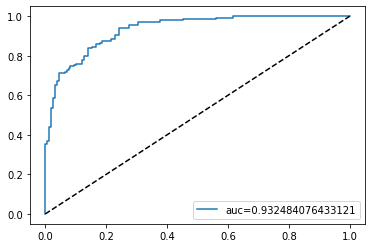

In [ ]:
oneClassTest = [painClass[1] for painClass in y_class_test]
oneClassPredict = [painClass[1] for painClass in predicts_class]

fpr, tpr, _ = sklearn.metrics.roc_curve(oneClassTest,  oneClassPredict)
auc = sklearn.metrics.roc_auc_score(oneClassTest, oneClassPredict)

plt.plot(fpr,tpr,label="auc="+str(auc))
plt.plot([0,1],[0,1],'k--')
plt.legend(loc=4)
plt.show()

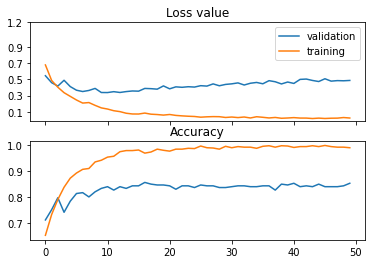

In [ ]:
#Plot the training records to observe any overfitting on the model.
records     = pd.read_csv(csvfilename)
plt.figure()
plt.subplot(211)
plt.plot(records['val_class_loss'], label="validation")
plt.plot(records['class_loss'],label="training")
plt.yticks([0.1,0.3,0.5,0.7,0.9,1.2])
plt.title('Loss value',fontsize=12)

ax          = plt.gca()
ax.set_xticklabels([])

plt.subplot(212)
plt.plot(records['val_class_accuracy'],label="validation")
plt.plot(records['class_accuracy'],label="training")
plt.title('Accuracy',fontsize=12)
ax.legend()
plt.show()

### Pain Expression

The mean squared error (MSE) on test set:0.5126529319337714


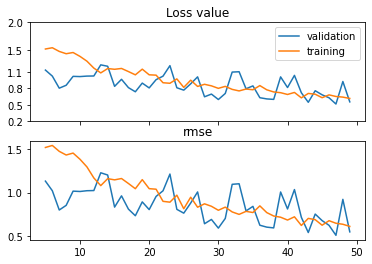

In [ ]:
#Plot the training records to observe any overfitting on the model.
testScores  = sklearn.metrics.mean_squared_error(y_reg_test,predicts_reg)

print(f"The mean squared error (MSE) on test set:{testScores}")

records     = pd.read_csv(csvfilename)
plt.figure()
plt.subplot(211)
plt.plot(records['val_reg_loss'][5:], label="validation")
plt.plot(records['reg_loss'][5:],label="training")
plt.yticks([0.2,0.5,0.8,1.1,1.5,2])
plt.title('Loss value',fontsize=12)

ax          = plt.gca()
ax.set_xticklabels([])

plt.subplot(212)
plt.plot(records['val_reg_mean_squared_error'][5:],label="validation")
plt.plot(records['reg_mean_squared_error'][5:],label="training")
plt.title('rmse',fontsize=12)
ax.legend()
plt.show()


In [ ]:
randomNumber = random.randint(0, X_test.shape[0]-1)
test = X_test[randomNumber]

print(f'Real pain recognition: {y_class_test[randomNumber]}')
print(f'Predicted pain recognition: {predicts_class[randomNumber].round()}\n')
print(f'Real pain intensity: {y_reg_test[randomNumber]}')
print(f'Predicted pain intensity: {predicts_reg[randomNumber][0]}\n')

Real pain recognition: [1 0]
Predicted pain recognition: [1. 0.]

Real pain intensity: [3.4444444]
Predicted pain intensity: 2.347642421722412

